# Experimentos Juego del Gato y el Ratón

Este notebook ejecuta y analiza **experimentos** del juego de Gato y Ratón, integrando en un único flujo:

- La batería de *pairings* específica.
- La exploración sistemática de **todas las combinaciones de algoritmos** en **dos mapas** (small y big), como en el notebook de registro de resultados.

A lo largo del notebook se generan y visualizan todos los gráficos necesarios para el informe, listos para ser exportados o reutilizados.


## 1. Imports y configuración general

In [1]:
%pip install pandas matplotlib

import random
import time
import statistics as st
from collections import Counter
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt

# Mapas
from scr.config_small import conexiones as conexiones_small, nodos as nodos_small
from scr.config_big import conexiones as conexiones_big, nodos as nodos_big

# Algoritmos
from scr.alg.alg_astar import gato_move_astar, raton_move_astar
from scr.alg.alg_minimax import gato_move_minimax, raton_move_minimax
from scr.alg.alg_random import gato_move_random, raton_move_random
from scr.alg.alg_entrenamiento import bfs_dist

print("Módulos importados correctamente.")



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
pygame 2.6.1 (SDL 2.28.4, Python 3.10.13)
Hello from the pygame community. https://www.pygame.org/contribute.html
Módulos importados correctamente.


## 2. Parámetros globales de los experimentos

En esta sección se definen los parámetros compartidos por ambas baterías de experimentos: número máximo de pasos por partida, combinaciones de algoritmos, etc.

In [2]:

# Número máximo de pasos por partida
MAX_PASOS = 200

# Número de episodios por combinación de algoritmos y mapa
EPISODIOS_POR_SETUP = 50

# Algoritmos disponibles para cada agente (para la batería 'todos contra todos') 
ALGORITMOS_GATO = ["random", "astar", "minimax"]
ALGORITMOS_RATON = ["random", "astar", "minimax"]

# Pairings específicos (batería estilo experiments_runner.py, usando mapa small por defecto)
PAIRINGS = [
    ("G_random vs R_astar", "random", "astar"),
    ("G_astar vs R_random", "astar", "random"),
    ("G_minmax vs R_astar", "minimax", "astar"),
    ("G_random vs R_minmax", "random", "minimax"),
    ("G_astar vs R_minmax", "astar", "minimax"),
    ("G_minmax vs R_random", "minimax", "random"),
    ("G_random vs R_random", "random", "random"),
    ("G_astar vs R_astar", "astar", "astar"),
    ("G_minmax vs R_minmax", "minimax", "minimax"),
]


MAX_PASOS, EPISODIOS_POR_SETUP, ALGORITMOS_GATO, ALGORITMOS_RATON, PAIRINGS


(200,
 50,
 ['random', 'astar', 'minimax'],
 ['random', 'astar', 'minimax'],
 [('G_random vs R_astar', 'random', 'astar'),
  ('G_astar vs R_random', 'astar', 'random'),
  ('G_minmax vs R_astar', 'minimax', 'astar'),
  ('G_random vs R_minmax', 'random', 'minimax'),
  ('G_astar vs R_minmax', 'astar', 'minimax'),
  ('G_minmax vs R_random', 'minimax', 'random'),
  ('G_random vs R_random', 'random', 'random'),
  ('G_astar vs R_astar', 'astar', 'astar'),
  ('G_minmax vs R_minmax', 'minimax', 'minimax')])

## 3. Funciones de movimiento y utilidades

Definimos funciones auxiliares para mover al gato y al ratón según el algoritmo elegido, así como la inicialización de una partida (posiciones iniciales, queso y meta).

In [3]:

def mover_gato(mode, pos_g, pos_r, conexiones, nodos):
    """Devuelve la nueva posición del gato según el modo seleccionado."""
    if mode == "astar":
        return gato_move_astar(conexiones, nodos, pos_g, pos_r)
    elif mode == "minimax":
        return gato_move_minimax(conexiones, nodos, pos_g, pos_r)
    elif mode == "random":
        return gato_move_random(conexiones, pos_g, pos_r)
    else:
        raise ValueError(f"Modo gato desconocido: {mode}")


def mover_raton(mode, pos_g, pos_r, queso, meta, tiene_queso, conexiones, nodos):
    """Devuelve la nueva posición del ratón según el modo seleccionado."""
    if mode == "astar":
        return raton_move_astar(conexiones, nodos, pos_g, pos_r, queso, meta, tiene_queso)
    elif mode == "minimax":
        # En este proyecto, minimax ignora queso/meta
        return raton_move_minimax(conexiones, nodos, pos_g, pos_r)
    elif mode == "random":
        return raton_move_random(conexiones, pos_g, pos_r)
    else:
        raise ValueError(f"Modo ratón desconocido: {mode}")


def inicializar_partida(conexiones, nodos, seed=None):
    """Elige al azar posiciones iniciales válidas para ratón, gato, queso y meta."""
    if seed is not None:
        random.seed(seed)
    nodos_ids = list(nodos.keys())
    pos_raton = random.choice(nodos_ids)
    pos_gato  = random.choice([n for n in nodos_ids if n != pos_raton])
    queso     = random.choice([n for n in nodos_ids if n not in (pos_raton, pos_gato)])
    meta      = random.choice([n for n in nodos_ids if n not in (pos_raton, pos_gato, queso)])

    return pos_gato, pos_raton, queso, meta


## 4. Simulación básica de una partida (winner, pasos, duración)

Devolviendo solo el ganador, la cantidad de pasos y la duración en segundos. Se utilizará para la batería de *pairings*.

In [4]:

def simular_un_juego(mode_gato, mode_raton, conexiones, nodos, max_pasos=200, seed=None):
    """
    Simula una partida completa y devuelve un dict con claves:
      - 'winner': 'gato' | 'raton' | 'empate'
      - 'pasos': número de turnos utilizados
      - 'duration': tiempo de simulación (wall-clock) en segundos
    """
    pos_gato, pos_raton, queso, meta = inicializar_partida(conexiones, nodos, seed=seed)
    tiene_queso = False
    turno = "raton"
    pasos = 0

    t0 = time.perf_counter()

    while pasos < max_pasos:
        if turno == "raton":
            pos_raton = mover_raton(mode_raton, pos_gato, pos_raton, queso, meta, tiene_queso, conexiones, nodos)
            # recoge queso
            if (not tiene_queso) and (pos_raton == queso):
                tiene_queso = True
            turno = "gato"
        else:
            pos_gato = mover_gato(mode_gato, pos_gato, pos_raton, conexiones, nodos)
            turno = "raton"

        pasos += 1

        # condiciones terminales
        if pos_gato == pos_raton:
            duration = time.perf_counter() - t0
            return {"winner": "gato", "pasos": pasos, "duration": duration}

        if tiene_queso and pos_raton == meta:
            duration = time.perf_counter() - t0
            return {"winner": "raton", "pasos": pasos, "duration": duration}

    duration = time.perf_counter() - t0
    return {"winner": "empate", "pasos": pasos, "duration": duration}


# Prueba rápida
simular_un_juego("astar", "random", conexiones_small, nodos_small, max_pasos=50, seed=123)


{'winner': 'gato', 'pasos': 2, 'duration': 1.3415992725640535e-05}

## 5. Simulación detallada de una partida (captura, escape, empate, distancia promedio)

Para el análisis más fino se utiliza una función que, además de la dinámica básica, registra si la partida terminó por **captura del ratón**, **escape** (ratón llega a la meta con queso) o **empate** (se agotan los pasos), y calcula la **distancia promedio gato–ratón** durante la partida usando `bfs_dist`.

In [5]:

def simular_partida(modo_g, modo_r, conexiones, nodos, max_pasos=200, seed=None):
    """
    Simula una partida y devuelve:
      - modo_gato, modo_raton
      - captura (1 si gana el gato)
      - escape  (1 si gana el ratón escapando con queso)
      - empate  (1 si nadie gana dentro de MAX_PASOS)
      - pasos   (pasos utilizados)
      - d_prom  (distancia promedio gato–ratón a lo largo de la partida)
    """
    pos_gato, pos_raton, queso, meta = inicializar_partida(conexiones, nodos, seed=seed)
    tiene_queso = False
    turno = "raton"
    pasos = 0

    captura = 0
    escape = 0
    empate = 0
    d_hist = []

    while pasos < max_pasos:
        # registrar distancia actual
        try:
            d = bfs_dist(conexiones, pos_gato, pos_raton)
        except Exception:
            # si hubiera algún problema con bfs_dist, registramos 0 como fallback
            d = 0
        d_hist.append(d)

        if turno == "raton":
            pos_raton = mover_raton(modo_r, pos_gato, pos_raton, queso, meta, tiene_queso, conexiones, nodos)
            if (not tiene_queso) and (pos_raton == queso):
                tiene_queso = True
            turno = "gato"
        else:
            pos_gato = mover_gato(modo_g, pos_gato, pos_raton, conexiones, nodos)
            turno = "raton"

        pasos += 1

        # condiciones terminales
        if pos_gato == pos_raton:
            captura = 1
            break

        if tiene_queso and pos_raton == meta:
            escape = 1
            break

    if not (captura or escape):
        empate = 1

    return {
        "modo_gato": modo_g,
        "modo_raton": modo_r,
        "captura": captura,
        "escape": escape,
        "empate": empate,
        "pasos": pasos,
        "d_prom": st.mean(d_hist) if d_hist else 0.0,
    }


# Prueba rápida
simular_partida("astar", "random", conexiones_small, nodos_small, max_pasos=50, seed=123)


{'modo_gato': 'astar',
 'modo_raton': 'random',
 'captura': 1,
 'escape': 0,
 'empate': 0,
 'pasos': 2,
 'd_prom': 1.5}

## 6. Batería de *pairings*

En esta sección se ejecutan los **nueve emparejamientos fijos** de algoritmos para gato y ratón sobre el mapa **small**, repitiendo cada configuración varias veces con distintas semillas.

Se registran:

- Ganador de la partida (`gato`, `raton`, `empate`).
- Número de pasos hasta el final.
- Tiempo de simulación en segundos.


In [6]:

def correr_pairings(pairings, conexiones, nodos, repetitions=20, seed_base=0, max_pasos=200):
    resultados = []
    for idx, (label, mg, mr) in enumerate(pairings):
        print(f"Pairing {idx+1}/{len(pairings)}: {label}")
        for i in range(repetitions):
            seed = seed_base + 1000*idx + i
            out = simular_un_juego(mg, mr, conexiones, nodos, max_pasos=max_pasos, seed=seed)
            out["pair"] = label
            out["mode_gato"] = mg
            out["mode_raton"] = mr
            out["seed"] = seed
            resultados.append(out)
    return pd.DataFrame(resultados)


df_pairings = correr_pairings(PAIRINGS, conexiones_small, nodos_small,
                                       repetitions=20, seed_base=0, max_pasos=MAX_PASOS)

out_dir = Path("resultados")
out_dir.mkdir(exist_ok=True)
df_pairings.to_csv(out_dir / "resultados_partidas_detalle.csv", index=False)
df_pairings.head()


Pairing 1/9: G_random vs R_astar
Pairing 2/9: G_astar vs R_random
Pairing 3/9: G_minmax vs R_astar
Pairing 4/9: G_random vs R_minmax
Pairing 5/9: G_astar vs R_minmax
Pairing 6/9: G_minmax vs R_random
Pairing 7/9: G_random vs R_random
Pairing 8/9: G_astar vs R_astar
Pairing 9/9: G_minmax vs R_minmax


,winner,pasos,duration,pair,mode_gato,mode_raton,seed
0,raton,7,0.000024,G_random vs R_astar,random,astar,0
1,raton,5,0.000012,G_random vs R_astar,random,astar,1
2,raton,5,0.000011,G_random vs R_astar,random,astar,2
3,raton,7,0.000014,G_random vs R_astar,random,astar,3
4,raton,7,0.000015,G_random vs R_astar,random,astar,4


### 6.1 Resumen y gráficos de los *pairings*

Se calcula la tasa de victoria del gato, del ratón y de empates para cada pairing, junto con la duración promedio de las partidas.

In [7]:

# Resumen por pairing
resumen_rows = []
for label, group in df_pairings.groupby("pair"):
    winners = Counter(group["winner"])
    total = len(group)
    tasa_gato = winners.get("gato", 0) / total
    tasa_raton = winners.get("raton", 0) / total
    tasa_empate = winners.get("empate", 0) / total
    pasos_prom = group["pasos"].mean()
    dur_prom = group["duration"].mean()

    resumen_rows.append({
        "pair": label,
        "tasa_gato": tasa_gato,
        "tasa_raton": tasa_raton,
        "tasa_empate": tasa_empate,
        "pasos_prom": pasos_prom,
        "dur_prom": dur_prom,
    })

df_pairings_resumen = pd.DataFrame(resumen_rows)
df_pairings_resumen.to_csv(out_dir / "resultados_pairings_resumen.csv", index=False)
df_pairings_resumen


,pair,tasa_gato,tasa_raton,tasa_empate,pasos_prom,dur_prom
0,G_astar vs R_astar,0.85,0.15,0.00,2.80,0.000009
1,G_astar vs R_minmax,0.90,0.10,0.00,3.60,0.000095
2,G_astar vs R_random,1.00,0.00,0.00,4.10,0.000009
3,G_minmax vs R_astar,0.25,0.75,0.00,6.30,0.000146
4,G_minmax vs R_minmax,0.00,0.05,0.95,190.35,0.006187
5,G_minmax vs R_random,0.00,1.00,0.00,53.60,0.001383
6,G_random vs R_astar,0.20,0.80,0.00,5.90,0.000014
7,G_random vs R_minmax,0.00,0.30,0.70,144.30,0.003060
8,G_random vs R_random,0.00,1.00,0.00,62.40,0.000048


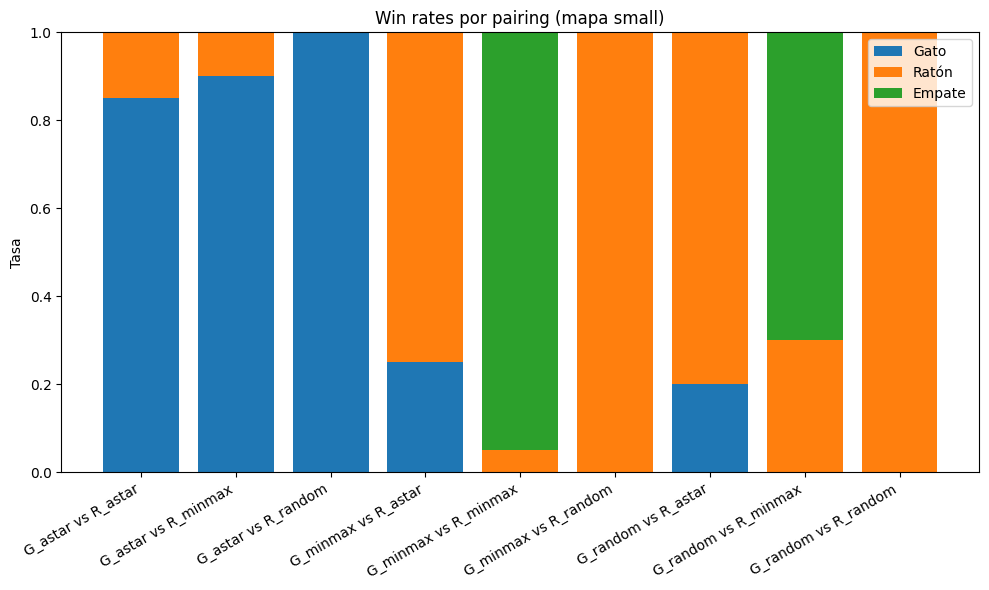

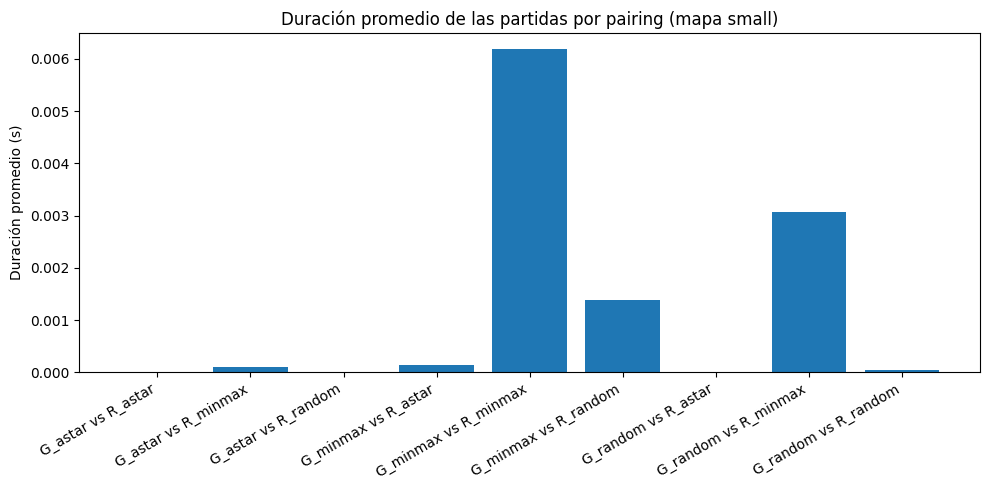

In [8]:

# 1) Win rates (gato / ratón / empate) por pairing
labels = df_pairings_resumen["pair"].tolist()
gato_rates = df_pairings_resumen["tasa_gato"].tolist()
raton_rates = df_pairings_resumen["tasa_raton"].tolist()
empate_rates = df_pairings_resumen["tasa_empate"].tolist()

x = range(len(labels))
plt.figure(figsize=(10, 6))
plt.bar(x, gato_rates, label="Gato")
plt.bar(x, raton_rates, bottom=gato_rates, label="Ratón")
bottom2 = [g + r for g, r in zip(gato_rates, raton_rates)]
plt.bar(x, empate_rates, bottom=bottom2, label="Empate")
plt.xticks(list(x), labels, rotation=30, ha="right")
plt.ylabel("Tasa")
plt.title("Win rates por pairing (mapa small)")
plt.legend()
plt.tight_layout()
plt.show()

# 2) Duración promedio por pairing (segundos)
plt.figure(figsize=(10, 5))
plt.bar(labels, df_pairings_resumen["dur_prom"].tolist())
plt.xticks(rotation=30, ha="right")
plt.ylabel("Duración promedio (s)")
plt.title("Duración promedio de las partidas por pairing (mapa small)")
plt.tight_layout()
plt.show()


## 7. Batería completa en ambos mapas (todos los algoritmos)

Ahora ejecutando **todas las combinaciones de algoritmos** para gato y ratón (`random`, `astar`, `minimax`) en los mapas `small` y `big`.
Para cada partida se registra si terminó por captura, escape o empate, junto con los pasos y la distancia promedio gato–ratón.

In [9]:

resultados_detalle = []

def correr_experimentos_para_mapa(nombre_mapa, conexiones, nodos):
    """Ejecuta todas las combinaciones de algoritmos en el mapa dado."""
    print(f"\n===== MAPA: {nombre_mapa} =====")
    for mg in ALGORITMOS_GATO:
        for mr in ALGORITMOS_RATON:
            print(f"Gato={mg} vs Ratón={mr}")
            for ep in range(EPISODIOS_POR_SETUP):
                seed = 10_000 + ep
                res = simular_partida(mg, mr, conexiones, nodos,
                                      max_pasos=MAX_PASOS,
                                      seed=seed)
                res["mapa"] = nombre_mapa
                resultados_detalle.append(res)

# Ejecutar en ambos mapas
correr_experimentos_para_mapa("small", conexiones_small, nodos_small)
correr_experimentos_para_mapa("big", conexiones_big, nodos_big)

df = pd.DataFrame(resultados_detalle)
df.head()



===== MAPA: small =====
Gato=random vs Ratón=random
Gato=random vs Ratón=astar
Gato=random vs Ratón=minimax
Gato=astar vs Ratón=random
Gato=astar vs Ratón=astar
Gato=astar vs Ratón=minimax
Gato=minimax vs Ratón=random
Gato=minimax vs Ratón=astar
Gato=minimax vs Ratón=minimax

===== MAPA: big =====
Gato=random vs Ratón=random
Gato=random vs Ratón=astar
Gato=random vs Ratón=minimax
Gato=astar vs Ratón=random
Gato=astar vs Ratón=astar
Gato=astar vs Ratón=minimax
Gato=minimax vs Ratón=random
Gato=minimax vs Ratón=astar
Gato=minimax vs Ratón=minimax


,modo_gato,modo_raton,captura,escape,empate,pasos,d_prom,mapa
0,random,random,0,1,0,135,1.644444,small
1,random,random,0,1,0,143,1.755245,small
2,random,random,0,1,0,33,1.727273,small
3,random,random,0,1,0,141,1.617021,small
4,random,random,0,1,0,67,1.641791,small


### 7.1 Resumen estadístico por mapa y combinación de algoritmos

Se agrupan los resultados por mapa y por configuración (modo del gato y modo del ratón), obteniendo las tasas promedio de captura, escape y empate, así como los pasos medios y la distancia promedio gato–ratón.

In [10]:

# Resumen por mapa + combinación de algoritmos
df_group = (
    df.groupby(["mapa", "modo_gato", "modo_raton"]).agg({
        "captura": "mean",
        "escape": "mean",
        "empate": "mean",
        "pasos": "mean",
        "d_prom": "mean",
    }).reset_index()
)

df_group


,mapa,modo_gato,modo_raton,captura,escape,empate,pasos,d_prom
0,big,astar,astar,0.98,0.02,0.00,4.10,1.785833
1,big,astar,minimax,1.00,0.00,0.00,4.56,1.921667
2,big,astar,random,1.00,0.00,0.00,4.80,1.873333
3,big,minimax,astar,0.12,0.88,0.00,9.44,1.593282
4,big,minimax,minimax,0.00,0.00,1.00,200.00,1.136100
5,big,minimax,random,0.00,0.56,0.44,147.08,1.485012
6,big,random,astar,0.04,0.96,0.00,9.24,2.075966
7,big,random,minimax,0.00,0.06,0.94,196.22,2.363778
8,big,random,random,0.00,0.58,0.42,140.78,2.248112
9,small,astar,astar,0.86,0.14,0.00,3.24,1.398738


### 7.2 Exportación de resultados a CSV

Se exportan dos archivos:

- `resultados_detalle.csv`: una fila por partida.
- `resultados_partidas_resumen.csv`: una fila por combinación (mapa, modo gato, modo ratón).

In [11]:

df.to_csv("resultados_detalle.csv", index=False)
df_group.to_csv("resultados_partidas_resumen.csv", index=False)
"Archivos CSV guardados en el directorio actual."


'Archivos CSV guardados en el directorio actual.'

### 7.3 Visualización de resultados por mapa

1. **Tasas de resultado** (captura, escape, empate) por configuración de algoritmos.
2. **Tasa de empate y pasos promedio** por configuración.

Se generan gráficos separados para cada mapa (`small` y `big`).

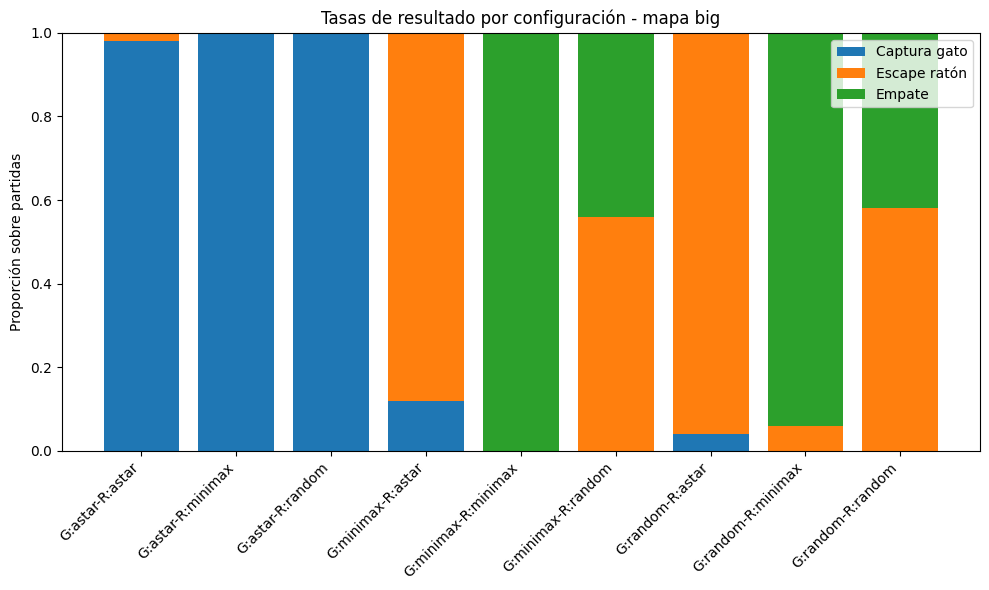

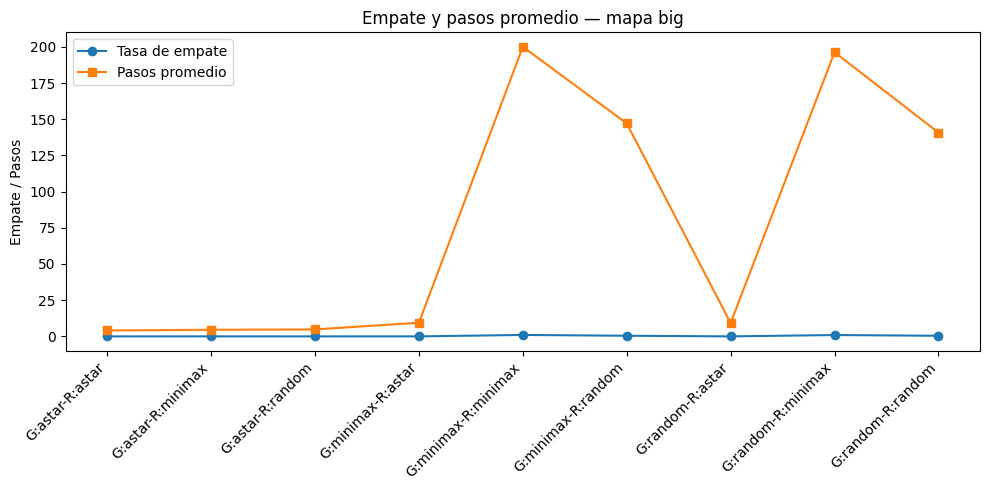

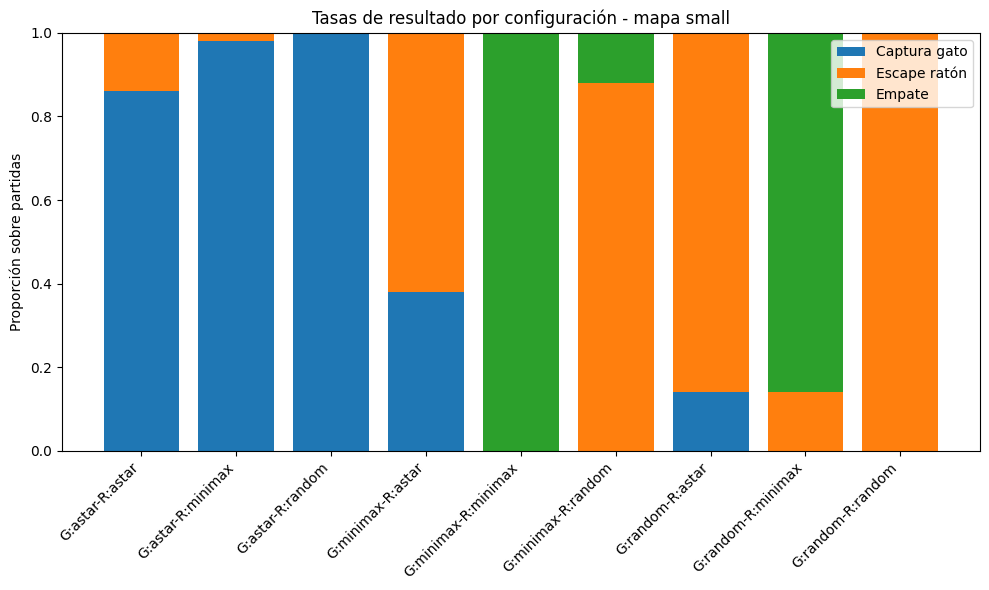

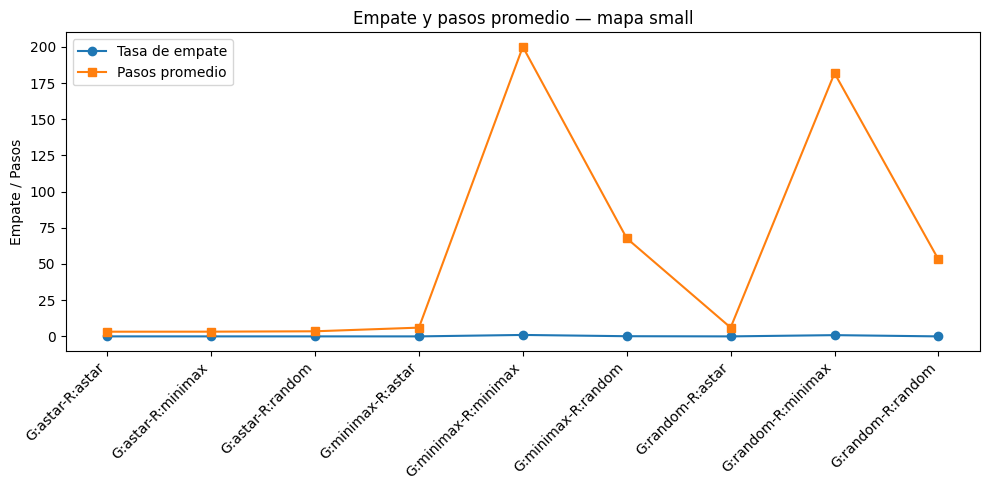

In [12]:

# Función auxiliar para armar etiqueta compacta
def etiqueta_fila(row):
    return f"G:{row['modo_gato']}-R:{row['modo_raton']}"

for mapa in df_group["mapa"].unique():
    sub = df_group[df_group["mapa"] == mapa].copy()
    etiquetas = sub.apply(etiqueta_fila, axis=1)
    x = range(len(sub))

    # Gráfico de barras apiladas: captura / escape / empate
    plt.figure(figsize=(10, 6))
    plt.title(f"Tasas de resultado por configuración - mapa {mapa}")
    plt.xticks(list(x), etiquetas, rotation=45, ha="right")
    plt.ylabel("Proporción sobre partidas")

    plt.bar(x, sub["captura"], label="Captura gato")
    plt.bar(x, sub["escape"], bottom=sub["captura"], label="Escape ratón")
    bottom_emp = sub["captura"] + sub["escape"]
    plt.bar(x, sub["empate"], bottom=bottom_emp, label="Empate")

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Gráfico de líneas: empate y pasos promedio
    plt.figure(figsize=(10, 5))
    plt.title(f"Empate y pasos promedio — mapa {mapa}")
    plt.xticks(list(x), etiquetas, rotation=45, ha="right")
    plt.ylabel("Empate / Pasos")

    plt.plot(x, sub["empate"], marker="o", label="Tasa de empate")
    plt.plot(x, sub["pasos"], marker="s", label="Pasos promedio")

    plt.legend()
    plt.tight_layout()
    plt.show()
